### Credit Risk Analysis

The goal is to create a model that will predict the probable risk of loss resulting from a borrower's failure to repay a loan. A good risk is one that is likely to be repaid because the loan is made to a creditworthy person and a bad risk is one that is unlikely to be repaid because of multiple factors like bad credit history, insufficient income, etc.

In [72]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

In [73]:
# load data
df = pd.read_csv(r"C:\Users\danog\Documents\DS Projects\German Credit Risk\dataset.csv",index_col=0)

In [74]:
# first look at the data
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [75]:
# explore missing values
df.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [76]:
# look at unique values in variables with missing values
print(df['Saving accounts'].unique())
print(df['Checking account'].unique())

[nan 'little' 'quite rich' 'rich' 'moderate']
['little' 'moderate' nan 'rich']


In [77]:
# handle missing values
df['Saving accounts'] = df['Saving accounts'].fillna('no_info')
df['Checking account'] = df['Checking account'].fillna('no_info')

In [78]:
# rename columns
df.rename({'Saving accounts':'Savings','Checking account':'Checking','Credit amount':'Credit'}, axis=1, inplace=True)

In [79]:
# replace strings in variable "Purpose" with shorter strings
df['Purpose'].replace(['radio/TV',  'furniture/equipment', 'domestic appliances', 'vacation/others'],
                      ['media', 'furniture', 'household', 'others'], inplace=True)

In [80]:
# replace numeric values in "Job" with text values
def job_title (row):
    if row['Job'] == 0:
        return 'unskilled nonresident'
    if row['Job'] == 1:
        return 'unskilled resident'
    if row['Job'] == 2:
        return 'skilled'
    if row['Job'] == 3:
        return 'highly skilled'

df['Job'] = df.apply(job_title, axis=1)

In [81]:
# change order of columns
df = df[['Risk', 'Age', 'Credit', 'Duration', 'Sex', 'Job', 'Housing', 'Savings', 'Checking', 'Purpose']].copy()

In [82]:
# create dataset for analysis -> analysis done only on 75% of the data, the remaining 25% is hold out for testing
df_train = df.iloc[:750,:]

### Data exploration

In [83]:
df_train.head()

,Risk,Age,Credit,Duration,Sex,Job,Housing,Savings,Checking,Purpose
0,good,67,1169,6,male,skilled,own,no_info,little,media
1,bad,22,5951,48,female,skilled,own,little,moderate,media
2,good,49,2096,12,male,unskilled resident,own,little,no_info,education
3,good,45,7882,42,male,skilled,free,little,little,furniture
4,bad,53,4870,24,male,skilled,free,little,little,car


In [84]:
df_train.describe(include='all')

,Risk,Age,Credit,Duration,Sex,Job,Housing,Savings,Checking,Purpose
count,750,750.000000,750.000000,750.000000,750,750,750,750,750,750
unique,2,NaN,NaN,NaN,2,4,3,5,4,8
top,good,NaN,NaN,NaN,male,skilled,own,little,no_info,car
freq,527,NaN,NaN,NaN,512,472,537,452,289,242
mean,NaN,35.229333,3201.690667,20.657333,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,11.264187,2754.958899,12.277441,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,19.000000,250.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,27.000000,1344.500000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,33.000000,2281.500000,18.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,41.000000,3940.500000,24.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
df_train.columns

Index(['Risk', 'Age', 'Credit', 'Duration', 'Sex', 'Job', 'Housing', 'Savings',
       'Checking', 'Purpose'],
      dtype='object')

In [86]:
num_cols = ['Age','Credit','Duration']
cat_cols = ['Sex','Job','Housing','Savings','Checking','Purpose']

#### Target variable analysis

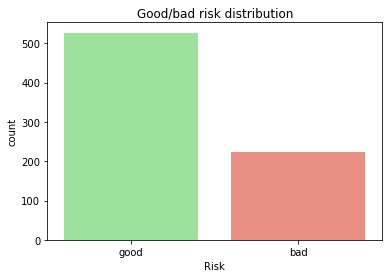

In [87]:
# count good/bad risk
sns.countplot(x = "Risk", data = df_train, palette=['lightgreen','salmon'])
plt.title("Good/bad risk distribution")
plt.show()

#### Numerical variables analysis

In [88]:
# function for creating charts for numeric data

def num_var_charts(var):
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,3), constrained_layout=True)
    fig.suptitle(var + ' analysis', fontsize=16)

    sns.histplot(x=var, data=df_train, color='grey', ax=ax1, bins=20, label='all')
    sns.histplot(x=df_train.loc[df_train['Risk']=='good',var], data=df_train, color='lightgreen', ax=ax1, bins=20, label='good')
    sns.histplot(x=df_train.loc[df_train['Risk']=='bad',var], data=df_train, color='salmon', ax=ax1, bins=20, label='bad')
    ax1.legend(loc=1)
    ax1.set_title('Distribution')    

    sns.kdeplot(x=var, data=df_train, color='grey', ax=ax2, label='all')
    sns.kdeplot(x=df_train.loc[df_train['Risk']=='good',var], data=df_train, color='lightgreen', ax=ax2, label='good')
    sns.kdeplot(x=df_train.loc[df_train['Risk']=='bad',var], data=df_train, color='salmon', ax=ax2, label='bad')
    ax2.legend(loc=1)
    ax2.set_title('KDE plot')
    
    plt.show()

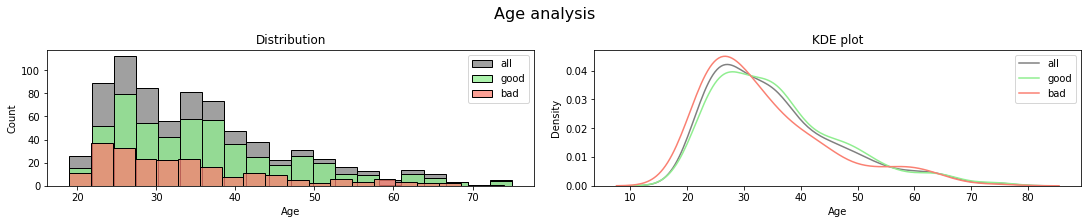

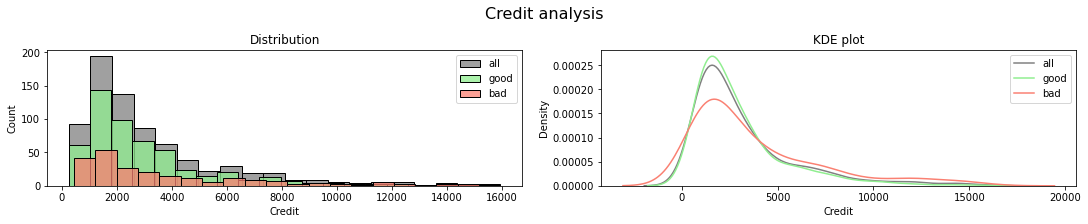

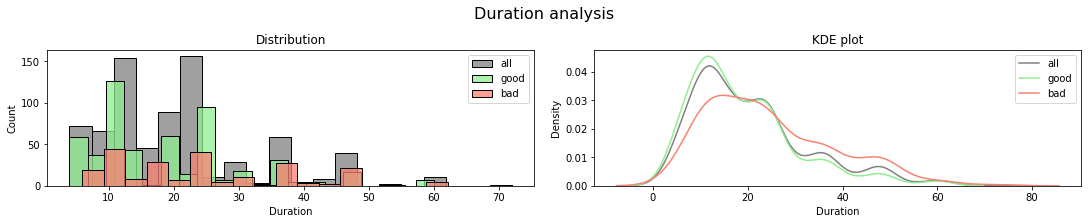

In [89]:
for i in num_cols:
    num_var_charts(i)

#### Categorical variables analysis

In [90]:
# function for getting stats for categorical data
def cat_var_stats(var):
    count = df_train[var].value_counts()
    count_bad = df_train[df_train['Risk']=='bad'][var].value_counts()
    count_good = df_train[df_train['Risk']=='good'][var].value_counts()
    df_var = (pd.concat([count.rename('count'), (count_bad/count).rename('bad %'), (count_good/count).rename('good %')], axis=1))
    df_var = df_var.reset_index().rename(columns={'index': var})
    return df_var

In [91]:
# function for creating charts for categorical variables
def cat_var_charts(var):

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,3), constrained_layout=True)
    fig.suptitle(var + ' analysis', fontsize=16)
    
    sns.countplot(x=var, hue='Risk', data = df_train, palette=['lightgreen','salmon'], ax=ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30) 
    ax1.set_title("Countplot")
    ax1.legend(loc=1)
    ax1.set(xlabel=None)
    
    cat_var_stats(var).plot.bar(x=var, y=['good %','bad %'], color=['lightgreen','salmon'], stacked=True, ax=ax2)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30)    
    ax2.set_title('Good/bad ratio')   
    ax2.legend(loc=1)
    ax2.set(xlabel=None)

    sns.boxplot(x=var, y='Credit', hue='Risk', palette=['lightgreen','salmon'], data=df_train, ax=ax3)
    ax3.set_title('Boxplot')   
    ax3.legend(loc=1)
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=30)
    ax3.set(xlabel=None)

    plt.show()

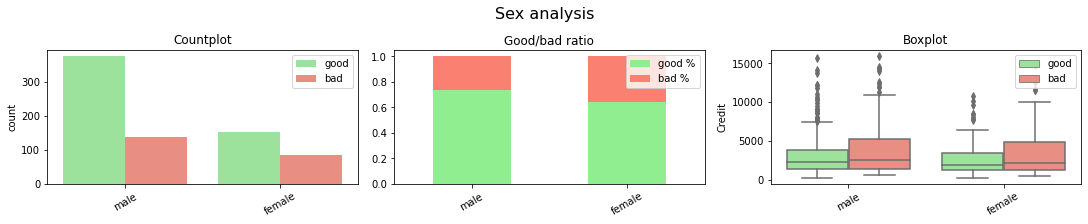

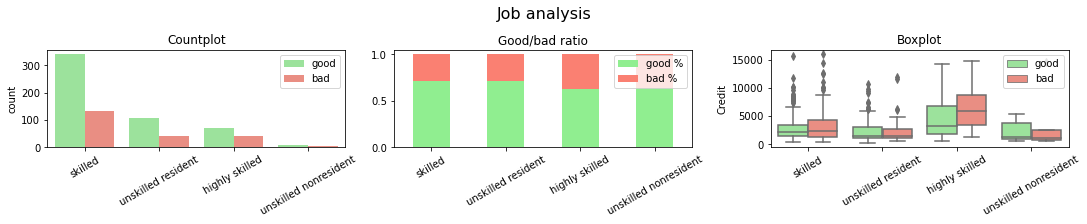

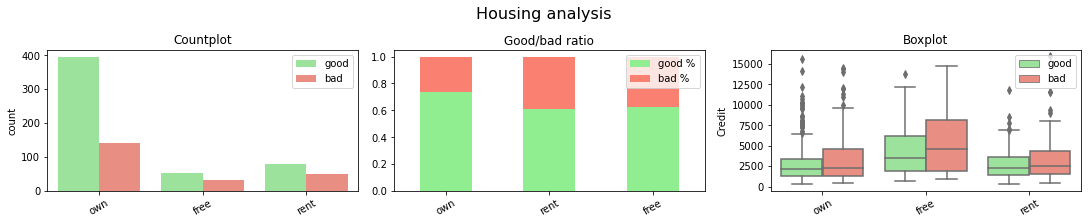

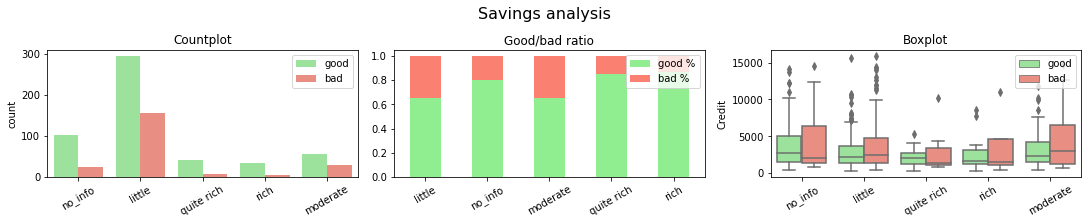

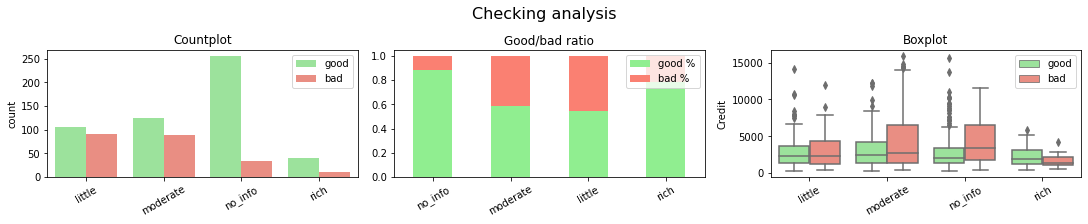

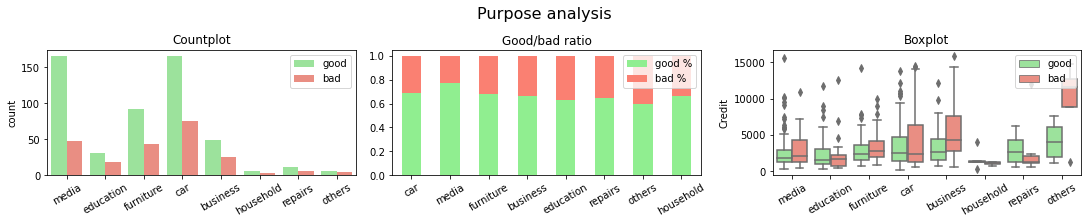

In [92]:
for i in cat_cols:
    cat_var_charts(i)

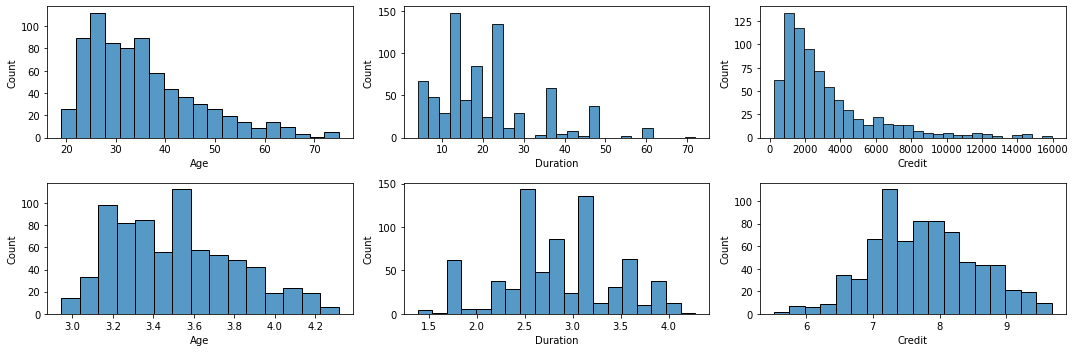

In [93]:
# exploring skeweness and looking at log-transformed data
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(15,5))
sns.histplot(x=df_train.Age, data=df_train, ax=ax1)
sns.histplot(x=df_train.Duration, data=df_train, ax=ax2)
sns.histplot(x=df_train.Credit, data=df_train, ax=ax3)
sns.histplot(x=np.log(df_train.Age), data=df_train, ax=ax4)
sns.histplot(x=np.log(df_train.Duration), data=df_train, ax=ax5)
sns.histplot(x=np.log(df_train.Credit), data=df_train, ax=ax6)
plt.tight_layout()
plt.show()

#### Data manipulation

In [94]:
# creating dummy variables
for i in cat_cols:
    df = df.merge(pd.get_dummies(df[i], drop_first=True, prefix=i), left_index=True, right_index=True)
    df.drop(columns=[i], inplace=True)

In [95]:
df.columns

Index(['Risk', 'Age', 'Credit', 'Duration', 'Sex_male', 'Job_skilled',
       'Job_unskilled nonresident', 'Job_unskilled resident', 'Housing_own',
       'Housing_rent', 'Savings_moderate', 'Savings_no_info',
       'Savings_quite rich', 'Savings_rich', 'Checking_moderate',
       'Checking_no_info', 'Checking_rich', 'Purpose_car', 'Purpose_education',
       'Purpose_furniture', 'Purpose_household', 'Purpose_media',
       'Purpose_others', 'Purpose_repairs'],
      dtype='object')

In [96]:
# log-transforming the skewed variables
for i in num_cols:
    df[i] = np.log(df[i])

In [97]:
# converting the target variable to binary data: 0=good, 1=bad
df['Risk'].replace(['good', 'bad'], [0,1], inplace=True)

In [98]:
# spliting df into train and test
X_train = df.iloc[:750,1:]
y_train = df.iloc[:750,0]
X_test = df.iloc[750:,1:]
y_test = df.iloc[750:,0]

In [99]:
# scaling the data with min-max scaler
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

#### Model building - Logistic regression

In [100]:
# defining the model, kfold, scores
model = LogisticRegression()
kfold = KFold(n_splits=10, shuffle=False)
scores = ['accuracy','precision','recall']

In [101]:
# first model -> logistic regression
table1 = pd.DataFrame(index=np.arange(10)) 

for i in scores:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=i)
    output = pd.DataFrame(cv_results, columns=[i])
    table1 = pd.merge(table1, output, left_index=True, right_index=True)
    
print(table1.mean())
print("\n")
print(table1.std())

accuracy     0.721333
precision    0.554310
recall       0.338244
dtype: float64


accuracy     0.070118
precision    0.153837
recall       0.134743
dtype: float64


In [102]:
# second model -> logistic regression with oversampling
table2 = pd.DataFrame(index=np.arange(10)) 

for i in scores:
    imba_pipeline = make_pipeline(SMOTE(random_state=42), model)
    cv_results = cross_val_score(imba_pipeline, X_train, y_train, cv=kfold, scoring=i)
    output = pd.DataFrame(cv_results, columns=[i])
    table2 = pd.merge(table2, output, left_index=True, right_index=True)
    
print(table2.mean())
print("\n")
print(table2.std())

accuracy     0.685333
precision    0.475006
recall       0.718035
dtype: float64


accuracy     0.049968
precision    0.067375
recall       0.131493
dtype: float64


In [103]:
# third model -> logistic regression with oversampling and feature elimination

rfe = RFE(model)
rfe = rfe.fit(X_train, y_train)
rfe_columns = X_train.columns[rfe.support_]

table3 = pd.DataFrame(index=np.arange(10)) 

for i in scores:
    imba_pipeline = make_pipeline(SMOTE(random_state=42), model)
    cv_results = cross_val_score(imba_pipeline, X_train[X_train.columns[rfe.support_]], y_train, cv=kfold, scoring=i)
    output = pd.DataFrame(cv_results, columns=[i])
    table3 = pd.merge(table3, output, left_index=True, right_index=True)
    
print(table3.mean())
print("\n")
print(table3.std())

accuracy     0.684000
precision    0.474134
recall       0.740310
dtype: float64


accuracy     0.041716
precision    0.068199
recall       0.123888
dtype: float64


### Testing the model on unseen (test) data

In [104]:
os = SMOTE(random_state=42)
X_train_os, y_train_os = os.fit_sample(X_train, y_train)
model.fit(X_train_os, y_train_os)
y_pred = model.predict(X_test)

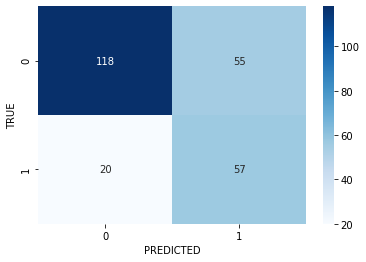

In [105]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel("PREDICTED")
plt.ylabel("TRUE")
plt.show()

In [106]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.68      0.76       173
           1       0.51      0.74      0.60        77

    accuracy                           0.70       250
   macro avg       0.68      0.71      0.68       250
weighted avg       0.75      0.70      0.71       250



### Results:
- from all 250 borrowers, 175 (70%) were correctly classified as either risky or not risky
- from the 77 borrowers that were actually risky, 57 (74%) were correctly classified as risky
- from the 173 borrowers that were actually not risky, 118 (68%) were correctly classified as not risky
- from the 112 borrowers classified as risky, only 57 (51%) were actually risky
- from the 138 borrowers classified as not risky, 118 (86%) were actually not risky